Task Description

The goal of this project is to build an audio classification model that assigns short speech recordings to one of three classes based on the speaking style:

0 – normal (normal voice)

1 – scream (shouted speech)

2 – whisper (whispered speech)

The dataset consists of single-word Polish speech recordings sampled at 16 kHz.
The semantic content of the words is irrelevant; only the vocal intensity and speaking mode matter.

# Starter code
provided by the competition organizers

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
import librosa
from typing import Callable
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from IPython.display import Audio
import gdown

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 12345

os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class WhisperScreamDataset(Dataset):
    def __init__(self, path: str) -> None:
        data = np.load(path, allow_pickle=True)

        self.signals = data["signals"]
        self.labels = data.get("labels", None)
        self.sr = int(data["sr"])

        if self.labels is None:
            self.labels = [-1] * len(self.signals)

    def __len__(self) -> int:
        return len(self.signals)

    def __getitem__(self, index: int) -> dict:
        sig = self.signals[index]
        label = self.labels[index]
        sig = torch.tensor(sig, dtype=torch.float32)
        return {"audio": sig, "label": label}


def setup_data(root: str = "data/") -> tuple:
    train_file = root + "train.npz"
    val_file = root + "val.npz"

    if not os.path.exists(root):
        os.makedirs(root)

    if not os.path.exists(train_file):
        url = "https://drive.google.com/uc?id=1WpPqcKTh_jzCsBm7k32IRtqlsxgpV8u4"
        gdown.download(url, train_file, quiet=True)

    if not os.path.exists(val_file):
        url = "https://drive.google.com/uc?id=1PwVhwFAGX3cS9gA7SYbJORjpQroPVQEN"
        gdown.download(url, val_file, quiet=True)

    train_ds = WhisperScreamDataset(train_file)
    val_ds = WhisperScreamDataset(val_file)

    return train_ds, val_ds

def predict(model_predict: Callable, dataset: Dataset) -> list:
    predicted = []

    for sample in dataset:
        x = sample["audio"].to(DEVICE)
        pred = model_predict(x)
        predicted.append(pred)

    return predicted


def calculate_balanced_accuracy(predicted: list, dataset: Dataset) -> float:
    expected = [sample["label"] for sample in dataset]
    return balanced_accuracy_score(y_true=expected, y_pred=predicted)

def evaluate_algorithm(your_model_predict: Callable, dataset: Dataset):
    your_out = predict(your_model_predict, dataset)

    your_balanced_accuracy = calculate_balanced_accuracy(your_out, dataset)
    score = (np.clip(your_balanced_accuracy, 0.6, 0.99) - 0.6) / (0.99 - 0.6) * 100
    score = int(round(score))

    print(f"Balanced accuracy on val_ds: {your_balanced_accuracy:.4f}")
    print(f"estimated points: {score}")

train_ds, val_ds = setup_data(root="data/")

print(f"train: {len(train_ds)}")
print(f"val: {len(val_ds)}")
print(f"{list(train_ds[0].keys())}")


train: 2400
val: 200
['audio', 'label']


## My solution
convolutional neural network (CNN) operating on log-Mel spectrograms to classify speech recordings into normal, scream, and whisper classes.

In [2]:
import matplotlib.pyplot as plt

class_names = {0: "normal", 1: "scream", 2: "whisper"}

samples_per_class = {0: [], 1: [], 2: []}

for sample in train_ds:
    label = sample["label"]
    if len(samples_per_class[label]) < 3:
        samples_per_class[label].append(sample["audio"].numpy())
    if all(len(v) == 3 for v in samples_per_class.values()):
        break

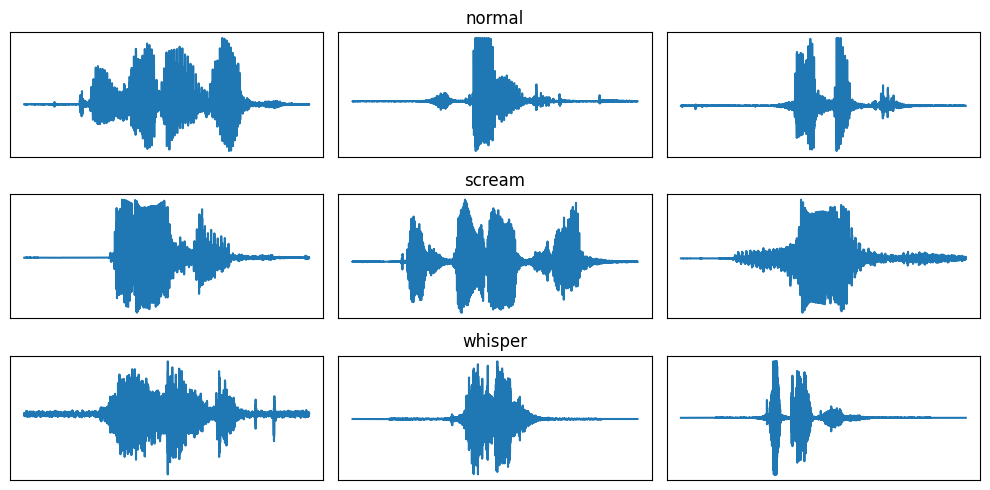

In [3]:
plt.figure(figsize=(10, 5))

for cls in range(3):
    for i, waveform in enumerate(samples_per_class[cls]):
        plt.subplot(3, 3, cls*3 + i + 1)
        plt.plot(waveform)
        plt.xticks([])
        plt.yticks([])
        if i == 1:
            plt.title(class_names[cls], fontsize=12)

plt.tight_layout()
plt.show()


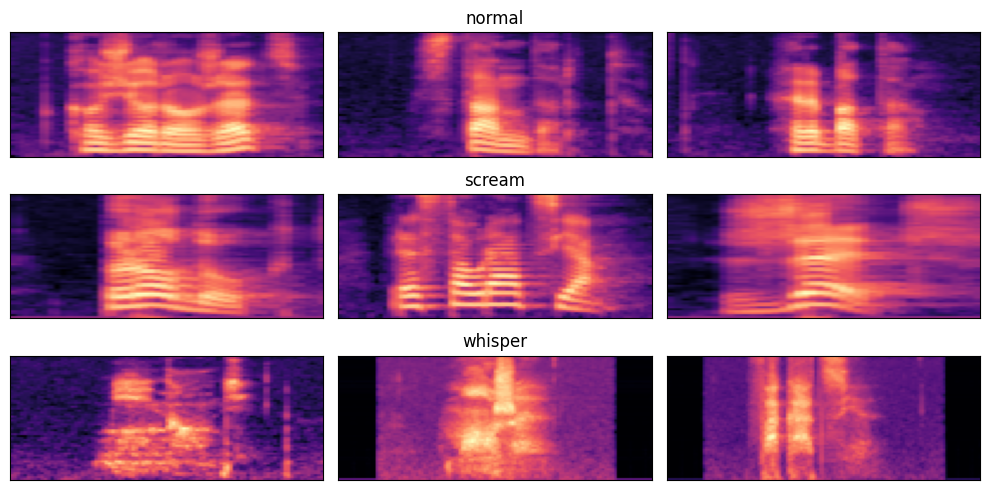

In [4]:
import torchaudio.transforms as T
melspec = T.MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=64)

plt.figure(figsize=(10,5))
for cls in range(3):
    for i, waveform in enumerate(samples_per_class[cls]):
        spec = melspec(torch.tensor(waveform))
        spec_db = 10 * torch.log10(spec + 1e-6)
        plt.subplot(3, 3, cls*3 + i + 1)
        plt.imshow(spec_db.numpy(), origin='lower', aspect='auto', cmap='magma')
        plt.xticks([])
        plt.yticks([])
        if i == 1:
            plt.title(class_names[cls])
plt.tight_layout()
plt.show()


In [5]:
#Tomasz Uram
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

def pad_collate(batch):
    audios = [item['audio'] for item in batch]
    labels = [item['label'] for item in batch]

    audios_padded = pad_sequence(audios, batch_first=True, padding_value=0.0)

    audios_padded = audios_padded.unsqueeze(1)
    labels = torch.tensor(labels).long()

    return audios_padded, labels

class YourClassifier(nn.Module):
    def __init__(self):
        super(YourClassifier, self).__init__()

        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            hop_length=256,
            n_mels=64
        )
        self.db_scale = torchaudio.transforms.AmplitudeToDB()

        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=35)


        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.squeeze(1)
        x = self.melspec(x)
        x = self.db_scale(x)

        x = x.unsqueeze(1)

        if self.training:
            x = self.freq_mask(x)
            x = self.time_mask(x)

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))

        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

    def predict(self, audio: torch.Tensor) -> list:
        self.eval()
        with torch.no_grad():
            if audio.ndim == 1:
                audio = audio.unsqueeze(0).unsqueeze(0)
            elif audio.ndim == 2:
                audio = audio.unsqueeze(1)

            device = next(self.parameters()).device
            audio = audio.to(device)

            logits = self.forward(audio)
            predictions = torch.argmax(logits, dim=1).cpu().tolist()

        return predictions

your_model = YourClassifier().to(DEVICE)


# Training

In [6]:
#TRENING
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

your_model = YourClassifier().to(DEVICE)

optimizer = optim.Adam(your_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 30

for epoch in range(epochs):
    your_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = your_model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{epochs}], loss: {avg_loss:.4f}")


Epoch [1/30], loss: 0.7151
Epoch [2/30], loss: 0.4925
Epoch [3/30], loss: 0.4246
Epoch [4/30], loss: 0.3446
Epoch [5/30], loss: 0.2979
Epoch [6/30], loss: 0.2844
Epoch [7/30], loss: 0.2642
Epoch [8/30], loss: 0.2372
Epoch [9/30], loss: 0.2215
Epoch [10/30], loss: 0.1980
Epoch [11/30], loss: 0.1962
Epoch [12/30], loss: 0.1924
Epoch [13/30], loss: 0.1881
Epoch [14/30], loss: 0.1689
Epoch [15/30], loss: 0.1437
Epoch [16/30], loss: 0.1350
Epoch [17/30], loss: 0.1928
Epoch [18/30], loss: 0.1523
Epoch [19/30], loss: 0.1663
Epoch [20/30], loss: 0.1423
Epoch [21/30], loss: 0.1143
Epoch [22/30], loss: 0.1488
Epoch [23/30], loss: 0.1652
Epoch [24/30], loss: 0.1615
Epoch [25/30], loss: 0.1435
Epoch [26/30], loss: 0.1244
Epoch [27/30], loss: 0.1154
Epoch [28/30], loss: 0.0838
Epoch [29/30], loss: 0.1331
Epoch [30/30], loss: 0.1401


# Evalutation

In [7]:
evaluate_algorithm(your_model.predict, val_ds)

Balanced accuracy on val_ds: 0.9949
estimated points: 100
